1. [Importación de paquetes necesarios](#1)

2. [Carga de datos](#2)

3. [Análisis descriptivo de los datos](#3)

4. [Imputacion de missings](#4)

5. [Transformación de variables](#5)

6. [Regresión logística](#6)
    1. [Evaluación del modelo](#7)

7. [KNN](#8)
    1. [Partición de los datos](#9)
    2. [Evaluación del modelo](#10)
    
8. [Árbol de decisión](#11)
    1. [Evaluación del modelo](#12)
    
9. [Ordenación de métodos según métricas](#13)

10. [Gráfica de importancias](#14)


# <span style="color:Green">Importación de paquetes necesarios</span><a id="1"></a> <br>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix

In [13]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# <span style="color:Green">Carga de datos</span><a id="2"></a> <br>

In [4]:
df = pd.read_csv('pd_data_initial_preprocessing.csv',
                 usecols=['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
                          'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
                          'verification_status', 'loan_status', 'purpose',"addr_state",
                          'dti',  'open_acc', 'pub_rec',
                          'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                          'mort_acc', 'pub_rec_bankruptcies'])
df.head()

,emp_title,emp_length,revol_util,dti,verification_status,annual_inc,home_ownership,sub_grade,grade,term,...,total_acc,purpose,addr_state,initial_list_status,application_type,pub_rec,pub_rec_bankruptcies,loan_amnt,mort_acc,open_acc
0,NaN,NaN,55.1,21.61,Not Verified,10000.0,OWN,1.0,C,36.0,...,6.0,credit_card,NY,w,Individual,0.0,0.0,2300.0,0.0,4.0
1,teacher,10.0,105.8,25.61,Not Verified,94000.0,MORTGAGE,1.0,C,60.0,...,26.0,debt_consolidation,MA,w,Individual,0.0,0.0,16000.0,7.0,9.0
2,Front Office,7.0,44.9,8.88,Not Verified,46350.0,MORTGAGE,4.0,C,36.0,...,27.0,home_improvement,MA,w,Individual,0.0,0.0,6025.0,2.0,11.0
3,Manager,10.0,18.7,27.06,Source Verified,44000.0,RENT,1.0,B,36.0,...,19.0,car,CA,w,Individual,0.0,0.0,20400.0,0.0,15.0
4,Paramedic,10.0,88.0,6.79,Source Verified,85000.0,MORTGAGE,5.0,B,36.0,...,24.0,debt_consolidation,MN,w,Individual,0.0,0.0,13000.0,1.0,5.0


In [5]:
df.shape

(884884, 23)

Vamos a ver de qué tipo es cada variable:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884884 entries, 0 to 884883
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   emp_title             832183 non-null  object 
 1   emp_length            833683 non-null  float64
 2   revol_util            884387 non-null  float64
 3   dti                   884615 non-null  float64
 4   verification_status   884876 non-null  object 
 5   annual_inc            884876 non-null  float64
 6   home_ownership        884876 non-null  object 
 7   sub_grade             884876 non-null  float64
 8   grade                 884876 non-null  object 
 9   term                  884876 non-null  float64
 10  int_rate              884876 non-null  float64
 11  installment           884876 non-null  float64
 12  loan_status           884876 non-null  object 
 13  total_acc             884876 non-null  float64
 14  purpose               884876 non-null  object 
 15  

# <span style="color:Green">Análisis descriptivo de los datos</span><a id="3"></a> <br>

Como hemos observado antes en la salida de `df.info()` hay variables con un gran numero de valores missing. También observamos que hay entradas que tienen un missing en cada columna. Como se trata de un número reducido (8) y no reprrsenta una gran pérdida de información procedmeos a eliminarlas.

In [7]:
df.isnull().sum()

emp_title               52701
emp_length              51201
revol_util                497
dti                       269
verification_status         8
annual_inc                  8
home_ownership              8
sub_grade                   8
grade                       8
term                        8
int_rate                    8
installment                 8
loan_status                 8
total_acc                   8
purpose                     8
addr_state                  8
initial_list_status         8
application_type            8
pub_rec                     8
pub_rec_bankruptcies        8
loan_amnt                   8
mort_acc                    8
open_acc                    8
dtype: int64

In [8]:
df[df['grade'].isna()]

,emp_title,emp_length,revol_util,dti,verification_status,annual_inc,home_ownership,sub_grade,grade,term,...,total_acc,purpose,addr_state,initial_list_status,application_type,pub_rec,pub_rec_bankruptcies,loan_amnt,mort_acc,open_acc
105451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
884882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
884883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observamos que las 8 observaciones que tienen NaN en alguna de las casillas y en grade son las mismas, 
procedemos a eliminarlas.

In [9]:
df = df[df['grade'].notna()]

También vemos que la variable _grade_ y la variable _subgrade_ nos aportan la misma información. Procedemos a eliminar _grade_.

In [10]:
df.drop("grade",axis =1, inplace = True) #la eliminamos porque sub_grade nos aporta lo mismo

Vamos a ver cómo de distribuyen los missings en el resto de variables:

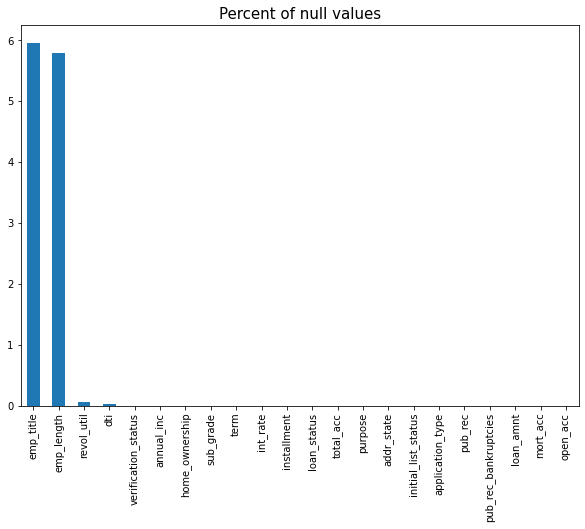

In [11]:
((df.isnull().sum()/len(df))*100).plot(kind = "bar", figsize = (10,7))
plt.title("Percent of null values",fontsize= 15)
plt.show()

In [12]:
df.describe( include= ["object"]).T

,count,unique,top,freq
emp_title,832183,214509,Teacher,17113
verification_status,884876,3,Source Verified,363463
home_ownership,884876,5,MORTGAGE,439600
loan_status,884876,7,Current,422685
purpose,884876,14,debt_consolidation,520846
addr_state,884876,51,CA,121479
initial_list_status,884876,2,w,568999
application_type,884876,2,Individual,863558


Las siguientes variables con mayor número de missings son `emp_title`,`emp_lenght`,`revol_util` y `dti`.  Vemos que `emp_title` toma muchos valores diferentes (214509) por lo que no interesaría imputarlos ya que no sería fiable. Procedemos a eliminarla:

In [13]:
df.drop(['emp_title'], 1, inplace = True)

<ipython-input-13-53865436c123>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['emp_title'], 1, inplace = True)


Vamos a ver como se distribuyen los diferentes valores de la variable objetivo:

In [14]:
df["loan_status"].value_counts(dropna = False)

Current               422685
Fully Paid            345520
Charged Off            97047
Late (31-120 days)     11168
In Grace Period         5507
Late (16-30 days)       2915
Default                   34
Name: loan_status, dtype: int64

#### Codificación de la variable objetivo:

Vamos a codificar la variable objetivo con los valores _pagado_ e _impago_. 

In [15]:
df['loan_status'] = df.loan_status.map({'Current': 'Pagado'
                                        , 'Fully Paid':'Pagado'
                                        , 'Charged Off': 'Impago'
                                        , 'Late (31-120 days)': 'Impago'
                                        , 'In Grace Period': 'Pagado'
                                        , 'Late (16-30 days)': 'Impago'
                                        , 'Default': 'Impago'})

In [16]:
df["loan_status"].value_counts(dropna = False)

Pagado    773712
Impago    111164
Name: loan_status, dtype: int64

<AxesSubplot:>

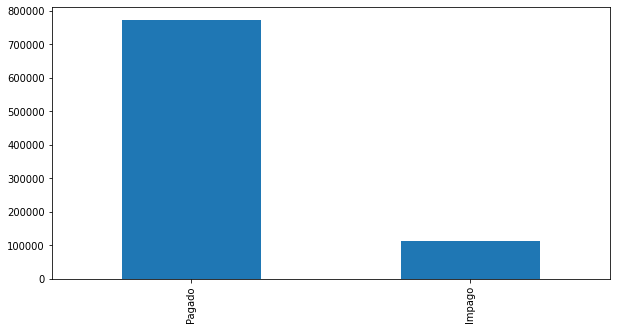

In [17]:
df["loan_status"].value_counts(dropna = False).plot(kind = "bar",figsize = (10,5))

Como podemos observar hay muchos mas pagados que impagados. Este desbalanceo será muy importante a tener en cuenta a la hora de aplicar los algoritmos sobre los datos, por ejemplo K-NN es susceptible a esta situación.

#### Matriz de correlaciones:

<AxesSubplot:>

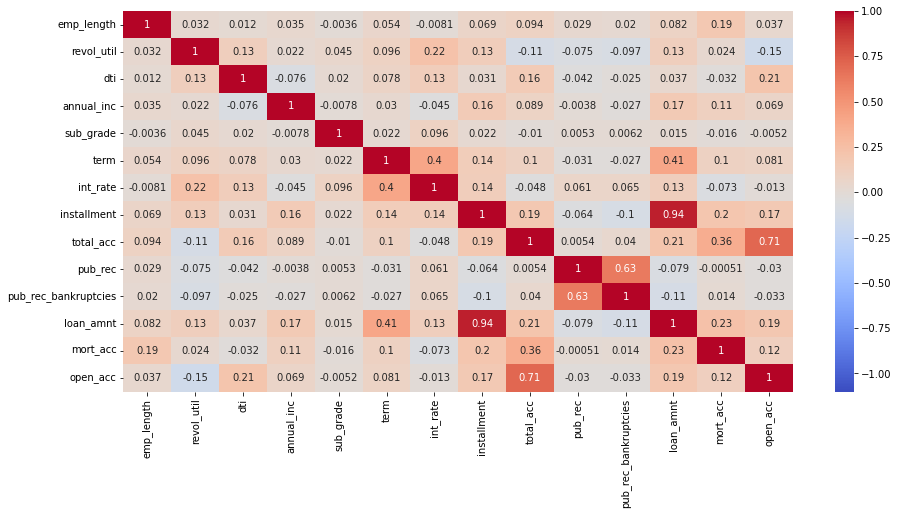

In [18]:
plt.figure(figsize= (15,7))
sns.heatmap(df.corr(), vmin=1, vmax=-1, annot=True, cmap="coolwarm")

Observamos que las variables que más se relacionan son `loan_amnt`y `installment` con una correlación del 0.94, `pub_rec_bankruptcies`y `pub_rec`con una correlación del 0.63 y `open_acc` y `total_acc`con una correlación del 0.71.

Vamos a codificar también la variable `home_ownership` para que sea más sencillo tratar sus datos:

In [19]:
df["home_ownership"].value_counts()

MORTGAGE    439600
RENT        350505
OWN          94752
ANY             16
NONE             3
Name: home_ownership, dtype: int64

In [20]:
df["home_ownership"]= df["home_ownership"].replace(["ANY","NONE"], "OTHER")

# <span style="color:Green">Imputación de missings</span><a id="4"></a> <br>

Generalmente, si la proporción de observaciones que faltan en los datos es pequeña en relación con el número total de observaciones, simplemente podemos eliminar esas observaciones, pero en pasos previos ya hemos determinado que `dti`, `revol_util` y `emp_lenght` deben ser imputadas en lugar de eliminarlas directamente debido a su importancia.

**KKN-Imputer** ayuda a imputar los valores faltantes presentes en las observaciones al encontrar los vecinos más cercanos con la matriz de distancia euclidiana lo cual es óptimo para las variables continuas `dti` y `revol_util`.

Para la variable `emp_lenght` procedemos a imputar la moda debido a su simplicidad.

In [ ]:
temp_values = df.dti.values.reshape(-1,1)
impute_knn = KNNImputer(n_neighbors=5)
impute_knn.fit_transform(temp_values)
transformed_values = impute_knn.transform(temp_values)
df.dti = transformed_values

temp_values2 = df.revol_util.values.reshape(-1,1)
impute_knn2 = KNNImputer(n_neighbors=5)
impute_knn2.fit_transform(temp_values2)
transformed_values2 = impute_knn2.transform(temp_values2)
df.revol_util = transformed_values2

df["emp_length"].fillna(df["emp_length"].mode()[0], inplace = True)

In [20]:
df.to_csv(r'Clean_Data.csv', index = False)

Guardamos en un csv los datos con los missings ya importados para no tener que volver a cargarlo todo si hay algún problema

In [3]:
df = pd.read_csv('Clean_Data.csv')

# <span style="color:Green">Transformación de variables</span><a id="5"></a> <br>

Transformamos las variables continuas, para poder posteriormente usar los algoritmos sin problemas.

In [4]:
df["loan_status"] = df["loan_status"].map({"Pagado":float(0),"Impago":float(1)})

In [5]:
df['verification_status'] = df.verification_status.map({'Verified': float(0), 'Source Verified': float(1), 'Not Verified': float(2)})
df['initial_list_status'] = df.initial_list_status.map({'w': float(0), 'f': float(1)})
df['application_type'] = df.application_type.map({'Individual': float(0), 'Joint App': float(1)})

In [6]:
le = LabelEncoder()

df['addr_state'] = le.fit_transform(df['addr_state'].astype(str))
df['sub_grade'] = le.fit_transform(df['sub_grade'].astype(str))
df['purpose'] = le.fit_transform(df['purpose'].astype(str))
df['emp_length'] = le.fit_transform(df['emp_length'].astype(str))
df['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884876 entries, 0 to 884875
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   emp_length            884876 non-null  int64  
 1   revol_util            884876 non-null  float64
 2   dti                   884876 non-null  float64
 3   verification_status   884876 non-null  float64
 4   annual_inc            884876 non-null  float64
 5   home_ownership        884876 non-null  int64  
 6   sub_grade             884876 non-null  int64  
 7   term                  884876 non-null  float64
 8   int_rate              884876 non-null  float64
 9   installment           884876 non-null  float64
 10  loan_status           884876 non-null  float64
 11  total_acc             884876 non-null  float64
 12  purpose               884876 non-null  int64  
 13  addr_state            884876 non-null  int64  
 14  initial_list_status   884876 non-null  float64
 15  

Como podemos observar ya no quedan tipos object, datos missing ni variables continuas. Por tanto podemos empezar a aplicar los algoritmos a los datos ya completamente preparados para aplicar estas metodologías.

# <span style="color:Green">Regresión logística</span><a id="6"></a> <br>

La regresión logística es uno de los algoritmos de aprendizaje automático más simples del temario, pero proporciona una gran eficiencia de entrenamiento en algunos casos, no requiere una gran potencia de cálculo e incluso podemos usarlo como modelo de referencia.

A continuación prepararemos un conjunto de entrenamiento y otro de test para ejecutar el algoritmo. Para los modelos de regresión logística, los datos de entrenamiento desequilibrados afectan a la estimación de la intersección del modelo y consecuentemente esto distorsiona todas las probabilidades predichas, lo que a su vez compromete sus predicciones. Por tanto, deberemos escalar el conjunto de entrenamiento para evitar los efectos negativos del desbalance.

## <span style="color:Green">Partición de los datos</span><a id="9"></a> <br>

In [8]:
X = df.drop("loan_status",axis =1 )
y= df["loan_status"]

# Dividimos datos y validamos nuestro modelo
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=0)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

log = linear_model.LogisticRegression(max_iter=10000)
log.fit(X_train_scaled,y_train)

X_test_scaled = scaler.transform(X_test)
y_pred = log.predict(X_test_scaled)

## <span style="color:Green">Modelo</span><a id="9"></a> <br>

In [9]:
name = "Logistic Regression"
kfold = model_selection.KFold(n_splits = 10)
cv_results = model_selection.cross_val_score(log, X_train, y_train, cv = kfold, scoring = "accuracy")
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

KeyboardInterrupt: 

## <span style="color:RED">Evaluación del modelo</span><a id="7"></a> <br>

Coeficientes de la regresión:

In [29]:
log.fit(X_train_scaled,y_train).coef_

array([[ 0.06225839,  0.48116073,  6.11047826, -0.31465149, -2.67895296,
         0.26645589, -0.05585464,  0.37247119,  2.33667997,  1.21529849,
         1.11840125, -0.2050586 , -0.02336322,  0.26469461, -2.0971252 ,
         1.42959939,  0.79446305, -1.00643824, -1.8216322 ,  0.17023951]])

In [30]:
print(accuracy_score(y_test, y_pred))

0.8727242591246238


A partir de la matriz de confusión podemos obtener la exactitud, precisión, sensiblidad y F-score de este modelo.
La exactitud del modelo («accuracy«) representa el porcentaje de predicciones correctas frente al total siendo un 87% un valor aceptable.
La precisión, (“precision”) se refiere a lo cerca que está el resultado de una predicción del valor verdadero. El valor obtenido para este modelo es de un 19%. Por tanto, nuestro modelo es bastante exacto pero poco preciso.
La sensibilidad ("recall") es la proporción entre los casos positivos bien clasificados por el modelo, respecto al total de positivos y por tanto representa la habilidad del modelo de detectar los casos relevantes. Un 0'2% es claramente un valor muy malo para una métrica. Por lo tanto, podemos decir que nuestro algoritmo de clasificación es poco sensible, «se le escapan» muchos positivos.

La regresión logística no parece el mejor algoritmo para modelizar este problema, pero confirmaremos la hipótesis con la curva de regresión logística.

/home/bdavidchj/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


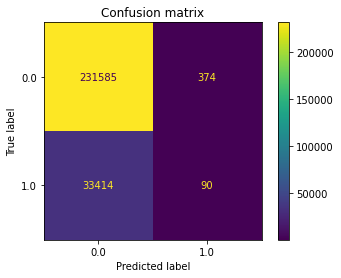

ACC:  0.8727204921213125
SEN:  0.0026862464183381087
ESP:  0.9983876460926284
PPV:  0.1939655172413793
FSC:  0.0052991050400376825


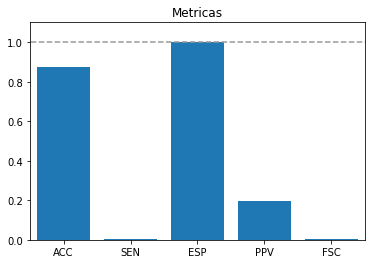

In [19]:
plot_confusion_matrix(log, X_test_scaled, y_test)
plt.title('Confusion matrix')
plt.show()

confmat = confusion_matrix(y_test,y_pred)
calcula_metricas(confmat)

La curva ROC es una medida del rendimiento del clasificador. Usando la proporción de puntos de datos positivos que se consideran correctamente como positivos y la proporción de puntos de datos negativos que se consideran erróneamente como positivos, generamos un gráfico que muestra el equilibrio entre la tasa a la que puede predecir algo correctamente con la tasa de predecir algo incorrectamente. En última instancia, nos preocupa el área bajo la curva ROC o AUROC. En este caso la métrica tiene un valor de 0'69. Al ser un valor menor a 0,80 podemos intuir que el modelo no hace un buen trabajo al discriminar entre las dos categorías que componen nuestra variable objetivo.

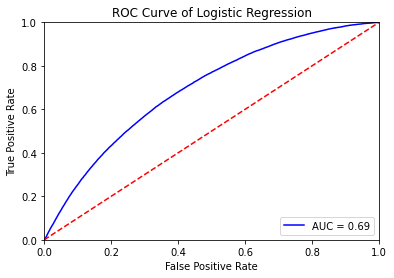

In [32]:
y_scores = log.predict_proba(X_test_scaled)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Curva de características operativas del receptor(ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

# <span style="color:Green">KNN</span><a id="8"></a> <br>

KNN (K-Nearest Neighbors) de aprendizaje automático que examina las etiquetas de un número elegido de puntos de datos que rodean un punto de datos de destino, para hacer una predicción sobre la clase en la que cae el punto de datos.
Este algoritmo slmacena el conjunto de datos de entrenamiento y aprende de él solo en el momento de hacer predicciones en tiempo real. Esto hace que el algoritmo KNN sea mucho más rápido que otros algoritmos que requieren entrenamiento, como el modelo de regresión lineal usado previamente.

A continuación prepararemos un conjunto de entrenamiento y otro de test para ejecutar el algoritmo. Para asegurar la eficiencia del algoritmo deberemos escalar el conjunto de entrenamiento.

## <span style="color:Green">Partición de los datos</span><a id="9"></a> <br>

In [38]:
# Dividimos datos:
cols = ['installment',"sub_grade",'total_acc','pub_rec_bankruptcies','home_ownership']
X = df[cols]
y= df["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 0)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

## <span style="color:Green">Modelo

In [37]:
ks = list(range(1, 15))
print(ks)

# En este diccionario iremos guardando las accuracies sobre test asociadas a cada valor de $k$
accs = {}
# Vamos recorriendo la rejilla con un bucle for...
for k in ks:
    print(k)
    # Definimos el modelo con el valor de hiperparámetro correspondiente
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Ajustamos a los datos de entrenamiento
    knn.fit(X_train, y_train)
    
    # Hacemos predicciones sobre los datos de test
    y_pred = knn.predict(X_test)
    
    # Evaluamos y guardamos la métrica correspondiente (en este caso accuracy)
    acc = metrics.accuracy_score(y_test, y_pred)
    
    accs[k] = acc
print(accs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
{1: 0.7923786276105235, 2: 0.8619775186089262, 3: 0.8429843594611699, 4: 0.8674095169213152, 5: 0.8601090920049423, 6: 0.8704080402615797, 7: 0.8668746044661423, 8: 0.8719901756923726, 9: 0.870159418979598, 10: 0.8727360395383178, 11: 0.8720203116053401, 12: 0.8732182141457976, 13: 0.8727812434077691, 14: 0.8735195732754724}


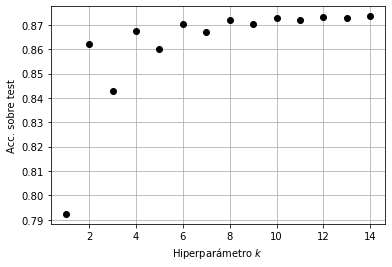

In [38]:
ks_arr = np.fromiter(accs.keys(), dtype=int)
accs_arr = np.fromiter(accs.values(), dtype=float)

plt.plot(ks_arr, accs_arr, 'ok')
plt.grid(True)
plt.xlabel('Hiperparámetro $k$');
plt.ylabel('Acc. sobre test');


Vemos que a partir de 8 Hiperparámetros no hay gran diferencia en cuanto a la accuracy, vamos a hacer KNN con 8 hiperparámetros.

In [39]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled,y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = knn.predict(X_test_scaled)

## <span style="color:RED">Evaluación del modelo</span><a id="10"></a> <br>

A partir de la matriz de confusión podemos obtener la exactitud, precisión, sensiblidad y F-score de este modelo. La exactitud del modelo («accuracy«) representa el porcentaje de predicciones correctas frente al total siendo un 87% un valor aceptable. La precisión, (“precision”) se refiere a lo cerca que está el resultado de una predicción del valor verdadero. El valor obtenido para este modelo es de un 17%. Por tanto, nuestro modelo es aún menos preciso que el de regresión logística previamente usado. La sensibilidad ("recall") es la proporción entre los casos positivos bien clasificados por el modelo, respecto al total de positivos y por tanto representa la habilidad del modelo de detectar los casos relevantes. Un 0'3% es claramente un valor no deseado para esta métrica pero supera al algoritmo anterior. Por lo tanto, podemos decir que nuestro algoritmo de clasificación también es poco sensible, «se le escapan» muchos positivos.

KNN no parece haber mejorado mucho las propiedades de su modelo respecto al modelo anterior aunque la exactitud sigue presentanto un valor aceptable.

/home/bdavidchj/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


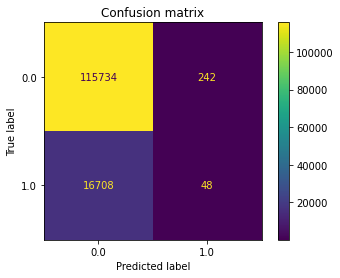

ACC:  0.8722990688002893
SEN:  0.0028646455001193603
ESP:  0.9979133613851142
PPV:  0.16551724137931034
FSC:  0.005631819781766983


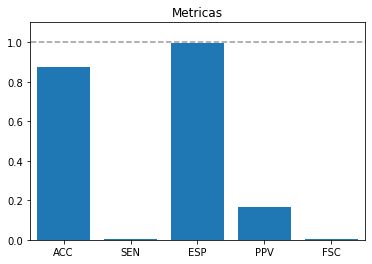

In [42]:
plot_confusion_matrix(knn, X_test_scaled, y_test)
plt.title('Confusion matrix')
plt.show()
confmat = confusion_matrix(y_test,y_pred)
calcula_metricas(confmat)

Observando la curva de características operativas del receptor (ROC), la métrica obtenida tiene un valor de 0'54. Ya que la métrica oscila entre los valores 0'50 y 1'00 siendo valores superiores a 0,80 modelos aptos, podemos intuir que el modelo no hace un buen trabajo al discriminar entre las dos categorías que componen nuestra variable objetivo.

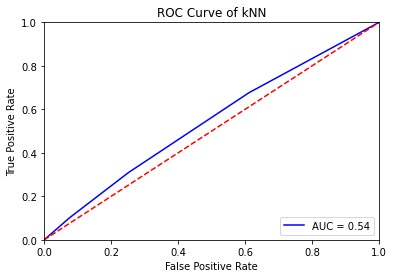

In [42]:
y_scores = knn.predict_proba(X_test_scaled)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Curva de características operativas del receptor(ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

# <span style="color:Green">Árbol de decisión</span><a id="11"></a> <br>

Un árbol de decisión es una técnica de aprendizaje automático que se puede utilizar para regresión y clasificación. Un árbol de decisión recibe su nombre porque el algoritmo divide el conjunto de datos en partes cada vez más pequeñas hasta que los datos se dividen en instancias únicas, que luego se clasifican.

Este algoritmo puede capturar relaciones no lineales y no requiere ninguna transformación de las características si se trata de datos no lineales ya que los árboles de decisión no tienen en cuenta múltiples combinaciones ponderadas simultáneamente. Por tanto esta vez no escalaremos el set de entrenamiento. Es un algoritmo rápidos y eficientes en comparación con KNN y ofrece fácil interpretación y visualización.

In [27]:
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

## <span style="color:Green">Partición de los datos</span><a id="9"></a> <br>

In [29]:
# Dividimos datos:
X = df.drop("loan_status",axis =1 )
y= df["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30,random_state = 0)

## <span style="color:Green">Modelo

In [54]:
# Con cross validation vemos cual es la mejor profundidad del arbol
from sklearn.model_selection import GridSearchCV
arbol = DecisionTreeClassifier()
scoring = ["accuracy"]
param_grid = {'max_depth': list(range(1,15))}
cv = GridSearchCV(arbol, param_grid, n_jobs = -1, scoring = "accuracy", cv=8)
cv.fit(X_train,y_train)
cv.best_estimator_ 

DecisionTreeClassifier(max_depth=1)

In [30]:
arbol = DecisionTreeClassifier(max_depth=1,class_weight = 'balanced')
arbol.fit(X_train,y_train)



arbol.score(X_test,y_test)


0.5046315305711153

In [31]:
y_pred = arbol.predict(X_test)

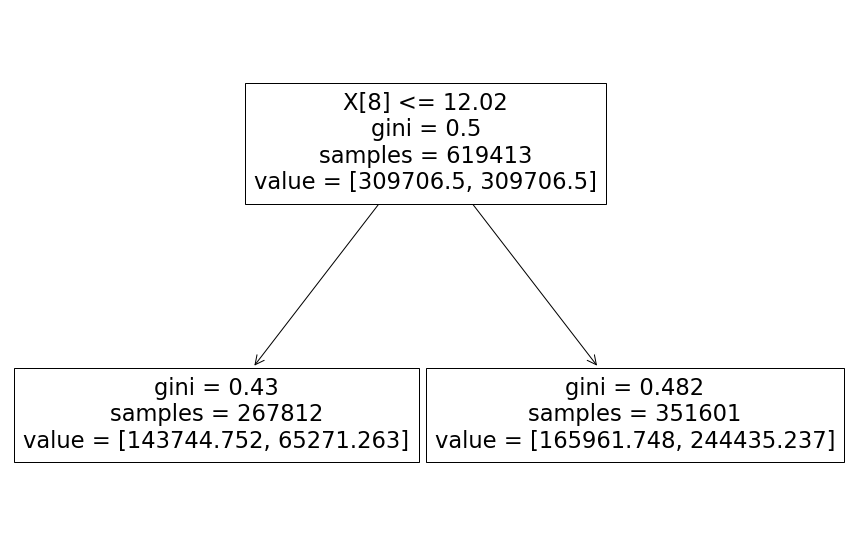

In [32]:
from sklearn import tree

plt.figure(figsize=(15, 10))
tree.plot_tree(arbol);


## <span style="color:RED">Evaluación del modelo</span><a id="12"></a> <br>

En este tercer algoritmo hemos obtenido datos bastantes diferentes, si bien KNN supuso una leve mejoría general sobre el algoritmo de regresión logística, en este modelo perdemos mucha exactitud siendo un 50% un valor que deja bastante a desear y una precisión bastante parecida a los otros dos modelos de un 17%. Sin embargo, este modelo resalta por sensibilidad de un 78% y por tanto este modelo destaca por su capacidad para detectar los casos relevantes. El método de árboles de decisión crea un modelo bastante sensible.

Accuracy:  0.5046315305711153


/home/bdavidchj/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


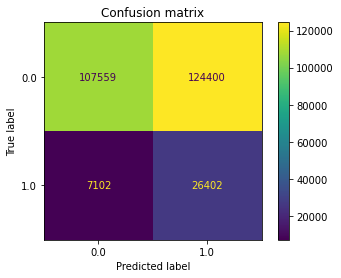

Precision 0.17507725361732604
Recall 0.7880253104106972
F-score 0.2865017959263399
ACC:  0.5046315305711153
SEN:  0.7880253104106972
ESP:  0.46369832599726674
PPV:  0.17507725361732604
FSC:  0.2865017959263399


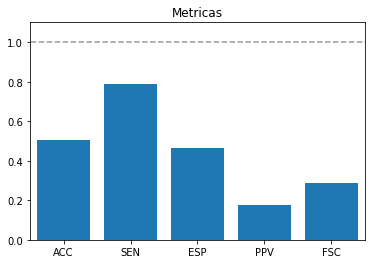

In [35]:
acc = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: ', acc)
 
plot_confusion_matrix(arbol, X_test, y_test)
plt.title('Confusion matrix')
plt.show()

prec = metrics.precision_score(y_test, y_pred)
print('Precision', prec)

rec = metrics.recall_score(y_test, y_pred)
print('Recall', rec)

f1 = metrics.f1_score(y_test, y_pred)
print('F-score', f1)


confmat = confusion_matrix(y_test,y_pred)
calcula_metricas(confmat)

Observando la curva de características operativas del receptor (ROC), la métrica obtenida tiene un valor de 0'63. Ya que la métrica oscila entre los valores 0'50 y 1'00 siendo valores superiores a 0,80 modelos aptos, podemos intuir que el modelo no hace un buen trabajo al discriminar entre las dos categorías que componen nuestra variable objetivo.

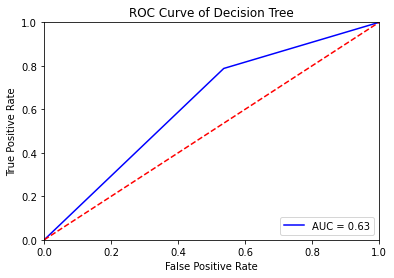

In [67]:
y_scores = arbol.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Curva de características operativas del receptor(ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

# <span style="color:Green">Ordenanción de métodos segun métricas</span><a id="13"></a> <br>

Puesto que la distribución entre ser un cliente que incumple con su préstamo es desigual a la de ser un cliente que sí cumple con él, creemos que F-SCORE (métrica que resume la precisión y sensibilidad) es la métrica más conveniente en este caso.Con lo cual atendiendo al F-SCORE los modelos ordenados de mayor a menor serían:






(1)ARBOL DE DECISIÓN (FSC=0.2865017959263399)

(2)KNN (FSC=0.005631819781766983)

(3)REGRESIÓN LOGÍSTICA (FSC=0.0052991050400376825)

# <span style="color:Green">Gráfica de importancias</span><a id="14"></a> <br>